# Machine Learning at Scale
Dr. James G. Shanahan and Marguerite Oneto, with assistance from Kasane Utsumi   
&copy; copyright July 2016


# The Heritage Health Prize Challenge Using Spark SQL

### Improve Healthcare, Win \$3,000,000.  Identify patients who will be admitted to a hospital within the next year using historical claims data.

This notebook uses [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html), [DataFrames](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame), and [Pipelines](https://spark.apache.org/docs/latest/ml-guide.html) to build a basic pipeline for modeling outcomes using the Heritage Health Prize dataset.

The notebook is organized as follows:  

1.  **Introduction**
2.  **Set Up Spark**
3.  **ETL**
4.  **Feature Engineering**
5.  **Modeling, Evaluation, and Tuning**
6.  **Results**
7.  **Next Steps**
8.  **Resources**
9.  **Appendix**

## Table of Contents <a name="TOC"></a> 

1.  [Introduction](#1)   
2.  [Set Up Spark](#2)
    1.  [Local Set-Up](#2.A)
    2.  [Docker Set-Up](#2.B)
    3.  [Cluster Set-Up](#2.C)
3.  [ETL](#3)
    1.  [Extract](#3.A)
    2.  [EDA-0](#3.B)
    3.  [Transform and Load](#3.C)
        1.  [Target Variables](#3.C.a)
        2.  [Claims Data](#3.C.b)
        3.  [Drug Data](#3.C.c)
        4.  [Lab Data](#3.C.d)
        5.  [Members Data](#3.C.e)
    4.  [EDA-1](#3.D)
4.  [Feature Engineering](#4)
    1.  [Aggregation](#4.A)
        1.  [Claims Data](#4.A.a)
        2.  [Drug Data](#4.A.b)
        3.  [Lab Data](#4.A.c)
    2.  [One Hot Encoding: Members Data](#4.B)
    3.  [Create Final DataFrame For Modeling](#4.C)
        1.  [Merge Data](#4.C.a)
        2.  [Handle Missing Data](#4.C.b)
        3.  [Drop Unnecessary Variables](#4.C.c)
        4.  [External Storage Read/Write of Final DataFrame](#4.C.d)
        5.  [EDA-2](#4.C.e)
5.  [Modeling, Evaluation, and Tuning](#5)
    1.  [Create Training, Validation, and Test DataFrames](#5.A)
    2.  [Define Evaluation Metric](#5.B)
    3.  [Build and Evaluate Baseline Model](#5.C)
    4.  [Feature Selection: Principal Component Analysis (PCA)](#5.D)
    5.  [Hyperparameter Tuning](#5.E)
6.  [Results](#6)
7.  [Next Steps](#7)
8.  [Resources](#8)
9.  [Appendix](#9)
    1.  [Runtimes](#9.A)
    2.  [Example of Training a Non-Linear Model Using Spark Pipelines](#9.B)
    3.  [User-Defined Functions in Spark Pipelines](#9.C)

## 1.  Introduction <a name="1"></a>
[Back to Table of Contents](#TOC)

[The Heritage Health Prize (HHP)](https://www.heritagehealthprize.com/c/hhp) was a data science challenge sponsored by [The Heritage Provider Network](http://www.heritageprovidernetwork.com).  It took place from April 4, 2011 to April 4, 2013.  For information on the winning entries, please see [here](http://www.heritagehealthprize.com/c/hhp/details/milestone-winners).

In this notebook, we follow a traditional data science project process to address the HHP challenge of predicting future hospital stays using past patient treatment information.  We extract, transform, and load the data (**ETL**).We conduct **feature engineering**.  Along the way, we do some exploratory data analysis (**EDA**).  We then **create models, evaluate their performance, and fine tune their parameters**.  We write up our **results**.  We explain what additional research we would like to do in a list of **next steps**.  We list our **resources**.  And finally, we create an **appendix** for tangential information related to our project.

These are the Python modules needed to run this notebook:

1.  pyspark
2.  pandas
3.  os
4.  sys
5.  math

## 2.  Set Up Spark <a name="2"></a>
[Back to Table of Contents](#TOC)

### 2.A Local Set-Up <a name="2.A"></a>
[Back to Table of Contents](#TOC)

Use this code to set up a spark context to run on your local computer.  Set the SPARK_HOME environment variable to the Spark directory being used on your local computer.

In [1]:
# # Replace the path below with your particular local Spark directory
# SPARK_HOME='/usr/local/Cellar/apache-spark/spark-1.6.2-bin-hadoop2.6/'

# import os
# import sys

# spark_home = os.environ['SPARK_HOME'] = SPARK_HOME
# if not spark_home:
#     raise ValueError('SPARK_HOME enviroment variable is not set')
# sys.path.insert(0, os.path.join(spark_home,'python'))
# sys.path.insert(0, os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))
# execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

# from pyspark.sql import SQLContext
# sql_context = SQLContext(sc)

In [2]:
# sc.stop()

### 2.B Docker Set-Up <a name="2.B"></a>
[Back to Table of Contents](#TOC)

Use this code to set up a Spark Context and a SQL Context to run on a Docker virtual machine on your local computer.

In [1]:
import os
import sys

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "hhp"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sql_context = SQLContext(sc)
print(sc)
print(sql_context)

### 2.C Cluster Set-Up <a name="2.C"></a>
[Back to Table of Contents](#TOC)

Use this code to set up a SQL Context when the cluster already has a Spark Context running.

In [2]:
sql_context = SQLContext(sc)
print sql_context

## 3.  ETL <a name="3"></a>
[Back to Table of Contents](#TOC)

 A copy of the HHP dataset can be downloaded [here](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AADp4D50rGM61hpaSThZnqF3a/HHP_release3?dl=0).  It consists of the following files:
1.  [Claims.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AADAkd0WulfgFthMibmIBtJoa/HHP_release3/Claims.csv?dl=0)  (Claims Data - features)
2.  [DaysInHospital_Y2.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAD0_gwrKFo657caVjV3mjZVa/HHP_release3/DaysInHospital_Y2.csv?dl=0)  (Target Data for Year 2 - labels)
3.  [DaysInHospital_Y3.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AACmJkf7txiQiPZ_jd5cqsf3a/HHP_release3/DaysInHospital_Y3.csv?dl=0)  (Target Data for Year 3 - labels)
4.  [DrugCount.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAA_9IxBOsoBSqyhlu7x8z2qa/HHP_release3/DrugCount.csv?dl=0)  (Drug Count Data - features)
5.  [LabCount.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AABxVuWLtBLqdYr6pyJCPsfga/HHP_release3/LabCount.csv?dl=0)  (Lab Count Data - features)
6.  [Members.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AACgVHEh2yUxzavQlurF8hfla/HHP_release3/Members.csv?dl=0)  (Members Data -features)
7.  [Target.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAD7M6yWTsRtToS7uKmbWrA7a/HHP_release3/Target.csv?dl=0)  (Target Data for Year 4 - labels)

The Extract-Transform-Load process will have three steps:  
1.  Extract  
2.  EDA-0  
3.  Transform and Load  

**NOTE: The data dictionary for the HHP data can be found [here](https://www.heritagehealthprize.com/c/hhp/data).**

<img src="https://dl.dropbox.com/s/d5u2et0xahnt2ct/HHP_DataDictionary.png" width="500" height="500" />

First, set the directory where the data can be found:

In [5]:
import os

# Set the directory containing the raw data files
DATA_DIR = os.path.join('HHP_release3')

### 3.A  Extract <a name="3.A"></a>
[Back to Table of Contents](#TOC)

Spark 1.6 does not have native support to load csv files directly into SQL DataFrames. We tried [Databrick's CSV Data Source package](https://github.com/databricks/spark-csv), but that did not work. Thus, we implemented a work-around by first reading the csv file into a pandas dataframe and then reading the pandas dataframe into a Spark SQL DataFrame.

In [30]:
import pandas as pd
from pyspark.sql.types import *

def load_csv_file(filename):
    # HACK - Loading csv directly into a dataframe was supposed to work by using a Databricks
    # package (https://github.com/databricks/spark-csv), but it didn't.
    # So in this section, we are going the Pandas -> DataFrame route.  Could also go RDD -> DataFrame route.
    
    # Set our file path
    input_path = os.path.join(DATA_DIR, filename)
    
    # Read into Pandas dataframe.  We assume the file contains a header row.
    # Note:  We read in all fields as string.
    df_pandas = pd.read_csv(input_path, dtype='str')  
    
    # Read Pandas dataframe into SQL DataFrame.
    # We must define the schema so that datatype is not automatically inferred and everything remains string.
    schema_string = df_pandas.columns.values.tolist()
    fields = [StructField(field_name, StringType(), True) for field_name in schema_string]
    schema = StructType(fields)
    
    return sql_context.createDataFrame(df_pandas, schema)

# Read in Year 2 Target Variables
df_target_Y2 = load_csv_file('DaysInHospital_Y2.csv').cache()
# Check the data
print "Schema for target_Y2 DataFrame with %d rows:" %(df_target_Y2.count())
df_target_Y2.printSchema()
df_target_Y2.show(1)

# Read in Year 3 Target Variables
df_target_Y3 = load_csv_file('DaysInHospital_Y3.csv').cache()
# Check the data
print "Schema for target_Y3 DataFrame with %d rows:" %(df_target_Y3.count())
df_target_Y3.printSchema()
df_target_Y3.show(1)

# Read in Year 4 Target Variables
df_target_Y4 = load_csv_file('Target.csv').cache()
# Check the data
print "Schema for target_Y4 DataFrame with %d rows:" %(df_target_Y4.count())
df_target_Y4.printSchema()
df_target_Y4.show(1)

# # Read in Claims Data
# df_claims = load_csv_file('Claims.csv').cache()
# # Check the data
# print "Schema for claims DataFrame with %d rows:" %(df_claims.count())
# df_claims.printSchema()
# df_claims.show(1)

# Read in Drug Data
df_drug_count = load_csv_file('DrugCount.csv').cache()
# Check the data
print "Schema for drug_count DataFrame with %d rows:" %(df_drug_count.count())
df_drug_count.printSchema()
df_drug_count.show(1)

# Read in Lab Data
df_lab_count = load_csv_file('LabCount.csv').cache()
# Check the data
print "Schema for lab_count DataFrame with %d rows:" %(df_lab_count.count())
df_lab_count.printSchema()
df_lab_count.show(1)

# Read in Members Data
df_members = load_csv_file('Members.csv').cache()
# Check the data
print "Schema for members DataFrame with %d rows:" %(df_members.count())
df_members.printSchema()
df_members.show(1)

Schema for target_Y2 DataFrame with 76038 rows:
root
 |-- MemberID: string (nullable = true)
 |-- ClaimsTruncated: string (nullable = true)
 |-- DaysInHospital: string (nullable = true)

+--------+---------------+--------------+
|MemberID|ClaimsTruncated|DaysInHospital|
+--------+---------------+--------------+
|24027423|              0|             0|
+--------+---------------+--------------+
only showing top 1 row

Schema for target_Y3 DataFrame with 71435 rows:
root
 |-- MemberID: string (nullable = true)
 |-- ClaimsTruncated: string (nullable = true)
 |-- DaysInHospital: string (nullable = true)

+--------+---------------+--------------+
|MemberID|ClaimsTruncated|DaysInHospital|
+--------+---------------+--------------+
|90963501|              0|             0|
+--------+---------------+--------------+
only showing top 1 row

Schema for target_Y4 DataFrame with 70942 rows:
root
 |-- MemberID: string (nullable = true)
 |-- ClaimsTruncated: string (nullable = true)
 |-- DaysInHospita

In [31]:
# # Then we can run some queries on the tt tables
# # Example: Count the number of samples in the Claims Data where the LengthOfStay is suppressed
# df_sup_los_1 = sql_context.sql("SELECT COUNT(MemberID) FROM claims_tt WHERE SupLOS = 1")
# print 'Number of samples in the Claims Data where the LengthOfStay is suppressed:'
# df_sup_los_1.show(1)
# df_sup_los_1.unpersist()
# # Example:  Get all possible values of the variable PrimaryConditionGroup
# df_pcg = sql_context.sql("SELECT DISTINCT(PrimaryConditionGroup) FROM claims_tt")
# print 'Possible Values for PrimaryConditionGroup:'
# df_pcg.show(df_pcg.count())

# # Free up memory
# sql_context.dropTempTable("claims_tt")

In [32]:
# TO DO:  EDA on each temp table above.

In [33]:
# # Method 2: Direct queries of DataFrames
# # DataFrame Operations:  https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

# # Example: Get counts of values in each column of Claims data
# print df_claims.columns
# columns_for_analysis = ['Year', 'Specialty', 'PlaceSvc', 'LengthOfStay', 'DSFS', 
#                         'PrimaryConditionGroup', 'CharlsonIndex', 'ProcedureGroup', 'SupLOS']
# for column in columns_for_analysis:
#     df_claims.groupBy(column).count().show()

In [34]:
# TO DO:  EDA on each DataFrame above.

### 3.C  Transform and Load <a name="3.C"></a>
[Back to Table of Contents](#TOC)

We use **Spark SQL Pipelines** to transform the data based on our findings in EDA-0.  Mostly, we are converting strings to numeric values.  We follow these steps:  

1.  Create the SQL statements to transform the data.  
2.  Create a SQL transformer for each statement.  
3.  Define a pipeline that runs all the SQL statements in order.  
4.  Fit/define a pipeline model.  
5.  Run the pipeline model to transform the data.  

The SQL statements used in this section are based on this [blog](http://anotherdataminingblog.blogspot.com/2011/10/code-for-respectable-hhp-model.html).

**NOTE: The SQLTransformer in pyspark.ml cannot execute all SQL commands.  This is because DataFrames are based on RDDs, and RDDs are immutable data structures.  Updating elements in place is not possible.  For example, instead of modifying an existing column with "UPDATE ... SET" as in traditional SQL, we must create a new column.  Refer to this [StackOverflow entry](http://stackoverflow.com/questions/29109916/updating-a-dataframe-column-in-spark).**

In [35]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer

#### 3.C.a  Target Variables <a name="3.C.a"></a>
[Back to Table of Contents](#TOC)

**NOTE: When we build our models below using pipelines, Spark expects that our target variable will have the name 'label'.  We creat 'label' here in the transformation step as LN(DaysInHospital + 1.0).  This is in line with the log root-mean-squared-error (log RMSE) loss function used by HHP to measure model performance.  See [here](https://www.heritagehealthprize.com/c/hhp/details/evaluation) for the original HHP explanation of their evaluation metric and [here](#5.B) in this notebook for a summary.**

In [36]:
# Step 1:  Create the SQL statements
# Convert strings to numbers and add Year
sql_0001_text = "SELECT MemberID, \
                 CAST(ClaimsTruncated AS INT) AS ClaimsTruncated, \
                 CAST(DaysInHospital AS DOUBLE) AS DaysInHospital, \
                 LN(DaysInHospital + 1.0) AS label, \
                 'Y1' AS Year \
                 FROM __THIS__"
sql_0002_text = "SELECT MemberID, \
                 CAST(ClaimsTruncated AS INT) AS ClaimsTruncated, \
                 CAST(DaysInHospital AS DOUBLE) AS DaysInHospital, \
                 LN(DaysInHospital + 1.0) AS label, \
                 'Y2' AS Year \
                 FROM __THIS__"
sql_0003_text = "SELECT MemberID, \
                 CAST(ClaimsTruncated AS INT) AS ClaimsTruncated, \
                 CAST(DaysInHospital AS DOUBLE) AS DaysInHospital, \
                 LN(DaysInHospital + 1.0) AS label, \
                 'Y3' AS Year \
                 FROM __THIS__"

# Step 2: Create the SQL transformers
sql_0001 = SQLTransformer(statement=(sql_0001_text))
sql_0002 = SQLTransformer(statement=(sql_0002_text))
sql_0003 = SQLTransformer(statement=(sql_0003_text))

# Step 3: Define the pipelines
transform_target_Y2_pipeline = Pipeline(stages=[sql_0001])
transform_target_Y3_pipeline = Pipeline(stages=[sql_0002])
transform_target_Y4_pipeline = Pipeline(stages=[sql_0003])

# Step 4: Fit the pipeline models
transform_target_Y2_pipeline_model = transform_target_Y2_pipeline.fit(df_target_Y2)
transform_target_Y3_pipeline_model = transform_target_Y3_pipeline.fit(df_target_Y3)
transform_target_Y4_pipeline_model = transform_target_Y4_pipeline.fit(df_target_Y4)

# Step 5: Run the pipeline model
df_target_Y2_transformed = transform_target_Y2_pipeline_model.transform(df_target_Y2).cache()
df_target_Y3_transformed = transform_target_Y3_pipeline_model.transform(df_target_Y3).cache()
df_target_Y4_transformed = transform_target_Y4_pipeline_model.transform(df_target_Y4).cache()

# Check the transformed data
print 'df_target_Y2_transformed has %d rows:' %(df_target_Y2_transformed.count())
print df_target_Y2_transformed.show(2)
print 'df_target_Y3_transformed has %d rows:' %(df_target_Y3_transformed.count())
print df_target_Y3_transformed.show(2)
print 'df_target_Y4_transformed has %d rows:' %(df_target_Y4_transformed.count())
print df_target_Y4_transformed.show(2)

# Free up memory
df_target_Y2.unpersist()
df_target_Y3.unpersist()
df_target_Y4.unpersist()

df_target_Y2_transformed has 76038 rows:
+--------+---------------+--------------+-----+----+
|MemberID|ClaimsTruncated|DaysInHospital|label|Year|
+--------+---------------+--------------+-----+----+
|24027423|              0|           0.0|  0.0|  Y1|
|98324177|              0|           0.0|  0.0|  Y1|
+--------+---------------+--------------+-----+----+
only showing top 2 rows

None
df_target_Y3_transformed has 71435 rows:
+--------+---------------+--------------+-----+----+
|MemberID|ClaimsTruncated|DaysInHospital|label|Year|
+--------+---------------+--------------+-----+----+
|90963501|              0|           0.0|  0.0|  Y2|
|85160905|              0|           0.0|  0.0|  Y2|
+--------+---------------+--------------+-----+----+
only showing top 2 rows

None
df_target_Y4_transformed has 70942 rows:
+--------+---------------+--------------+-----+----+
|MemberID|ClaimsTruncated|DaysInHospital|label|Year|
+--------+---------------+--------------+-----+----+
|20820036|            

DataFrame[MemberID: string, ClaimsTruncated: string, DaysInHospital: string]

#### 3.C.b  Claims Data <a name="3.C.b"></a>
[Back to Table of Contents](#TOC)

In [37]:
# # Step 1:  Create the SQL statements
# # Convert strings to numbers
# sql_0001_text = "SELECT *, \
#                  CASE WHEN PayDelay = '162+' THEN 163 ELSE (CAST(PayDelay AS INT)) END AS PayDelayI \
#                  FROM __THIS__"
# sql_0002_text = "SELECT *, \
#                  CASE \
#                  WHEN DSFS = '0- 1 month' THEN 1 \
#                  WHEN DSFS = '1- 2 months' THEN 2 \
#                  WHEN DSFS = '2- 3 months' THEN 3 \
#                  WHEN DSFS = '3- 4 months' THEN 4 \
#                  WHEN DSFS = '4- 5 months' THEN 5 \
#                  WHEN DSFS = '5- 6 months' THEN 6 \
#                  WHEN DSFS = '6- 7 months' THEN 7 \
#                  WHEN DSFS = '7- 8 months' THEN 8 \
#                  WHEN DSFS = '8- 9 months' THEN 9 \
#                  WHEN DSFS = '9-10 months' THEN 10 \
#                  WHEN DSFS = '10-11 months' THEN 11 \
#                  WHEN DSFS = '11-12 months' THEN 12 \
#                  WHEN DSFS IS NULL THEN NULL \
#                  END \
#                  AS DSFSI \
#                  FROM __THIS__"
# sql_0003_text = "SELECT *, \
#                  CASE \
#                  WHEN CharlsonIndex = '0' THEN 0 \
#                  WHEN CharlsonIndex = '1-2' THEN 2 \
#                  WHEN CharlsonIndex = '3-4' THEN 4 \
#                  WHEN CharlsonIndex = '5+' THEN 6 \
#                  END \
#                  AS CharlsonIndexI \
#                  FROM __THIS__"
# sql_0004_text = "SELECT *, \
#                  CASE \
#                  WHEN LengthOfStay = '1 day' THEN 1 \
#                  WHEN LengthOfStay = '2 days' THEN 2 \
#                  WHEN LengthOfStay = '3 days' THEN 3 \
#                  WHEN LengthOfStay = '4 days' THEN 4 \
#                  WHEN LengthOfStay = '5 days' THEN 5 \
#                  WHEN LengthOfStay = '6 days' THEN 6 \
#                  WHEN LengthOfStay = '1- 2 weeks' THEN 11 \
#                  WHEN LengthOfStay = '2- 4 weeks' THEN 21 \
#                  WHEN LengthOfStay = '4- 8 weeks' THEN 42 \
#                  WHEN LengthOfStay = '26+ weeks' THEN 180 \
#                  WHEN LengthOfStay IS NULL THEN null \
#                  END \
#                  AS LengthOfStayI \
#                  FROM __THIS__"

# # Step 2: Create the SQL transformers
# sql_0001 = SQLTransformer(statement=(sql_0001_text))
# sql_0002 = SQLTransformer(statement=(sql_0002_text))
# sql_0003 = SQLTransformer(statement=(sql_0003_text))
# sql_0004 = SQLTransformer(statement=(sql_0004_text))

# # Step 3: Define the pipeline
# transform_claims_pipeline = Pipeline(stages=[sql_0001, sql_0002, sql_0003, sql_0004])

# # Step 4: Fit the pipeline model
# transform_claims_pipeline_model = transform_claims_pipeline.fit(df_claims)

# # Step 5: Run the pipeline model
# df_claims_transformed = transform_claims_pipeline_model.transform(df_claims).cache()

# # Check the transformed data
# print 'df_claims_transformed has %d rows:' %(df_claims_transformed.count())
# print df_claims_transformed.show(2)

# # Free up memory
# df_claims.unpersist()

#### 3.C.c  Drug Data <a name="3.C.c"></a>
[Back to Table of Contents](#TOC)

In [38]:
# Step 1:  Create the SQL statements
# Convert strings to numbers
sql_0001_text = "SELECT *, \
                 CASE WHEN DrugCount = '7+' THEN 7 ELSE (CAST(DrugCount AS INT)) END AS DrugCountI \
                 FROM __THIS__"

# Step 2: Create the SQL transformers
sql_0001 = SQLTransformer(statement=(sql_0001_text))

# Step 3: Define the pipeline
transform_drugs_pipeline = Pipeline(stages=[sql_0001])

# Step 4: Fit the pipeline model
transform_drugs_pipeline_model = transform_drugs_pipeline.fit(df_drug_count)

# Step 5: Run the pipeline model
df_drug_count_transformed = transform_drugs_pipeline_model.transform(df_drug_count).cache()

# Check the transformed data
print 'df_drug_count_transformed has %d rows:' %(df_drug_count_transformed.count())
print df_drug_count_transformed.show(2)

# Free up memory
df_drug_count.unpersist()

df_drug_count_transformed has 818241 rows:
+--------+----+-----------+---------+----------+
|MemberID|Year|       DSFS|DrugCount|DrugCountI|
+--------+----+-----------+---------+----------+
|48925661|  Y2|9-10 months|       7+|         7|
|90764620|  Y3|8- 9 months|        3|         3|
+--------+----+-----------+---------+----------+
only showing top 2 rows

None


DataFrame[MemberID: string, Year: string, DSFS: string, DrugCount: string]

#### 3.C.d  Lab Data <a name="3.C.d"></a>
[Back to Table of Contents](#TOC)

In [39]:
# Step 1:  Create the SQL statements
# Convert strings to numbers
sql_0001_text = "SELECT *, \
                 CASE WHEN LabCount = '10+' THEN 10 ELSE (CAST(LabCount AS INT)) END AS LabCountI \
                 FROM __THIS__"

# Step 2: Create the SQL transformers
sql_0001 = SQLTransformer(statement=(sql_0001_text))

# Step 3: Define the pipeline
transform_labs_pipeline = Pipeline(stages=[sql_0001])

# Step 4: Fit the pipeline model
transform_labs_pipeline_model = transform_labs_pipeline.fit(df_lab_count)

# Step 5: Run the pipeline model
df_lab_count_transformed = transform_labs_pipeline_model.transform(df_lab_count).cache()

# Check the transformed data
print 'df_lab_count_transformed has %d rows:' %(df_lab_count_transformed.count())
print df_lab_count_transformed.show(2)

# Free up memory
df_lab_count.unpersist()

df_lab_count_transformed has 361484 rows:
+--------+----+-----------+--------+---------+
|MemberID|Year|       DSFS|LabCount|LabCountI|
+--------+----+-----------+--------+---------+
|69258001|  Y3|2- 3 months|       1|        1|
|10143167|  Y1| 0- 1 month|       2|        2|
+--------+----+-----------+--------+---------+
only showing top 2 rows

None


DataFrame[MemberID: string, Year: string, DSFS: string, LabCount: string]

### 3.D  EDA-1 <a name="3.D"></a>
[Back to Table of Contents](#TOC)

It is a best practice to do some EDA on each table to get a feel for the categorical variables, to see the distributions of the numeric variables, etc.  See [here](http://itl.nist.gov/div898/handbook/eda/eda.htm) for a comprehensive list of EDA techniques and the graphs [here](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/kmbgrkhh73931lo/Titanic-EDA-LogisticRegression.ipynb) for inspiration from the [Titanic Kaggle competition](https://www.kaggle.com/c/titanic).  Also see [Section 7: Next Steps](#7.).

In [15]:
# TO DO: EDA on df_target_Y2_transformed, df_target_Y3_transformed, df_target_Y4_transformed, df_claims_transformed,
#        df_drug_count_transformed, df_lab_count_transformed, df_members

In [40]:
print df_target_Y2_transformed.take(1)
print df_target_Y3_transformed.take(1)
print df_target_Y4_transformed.take(1)
# print df_claims_transformed.take(1)
print df_drug_count_transformed.take(1)
print df_lab_count_transformed.take(1)
print df_members.take(1)

[Row(MemberID=u'24027423', ClaimsTruncated=0, DaysInHospital=0.0, label=0.0, Year=u'Y1')]
[Row(MemberID=u'90963501', ClaimsTruncated=0, DaysInHospital=0.0, label=0.0, Year=u'Y2')]
[Row(MemberID=u'20820036', ClaimsTruncated=0, DaysInHospital=nan, label=None, Year=u'Y3')]
[Row(MemberID=u'48925661', Year=u'Y2', DSFS=u'9-10 months', DrugCount=u'7+', DrugCountI=7)]
[Row(MemberID=u'69258001', Year=u'Y3', DSFS=u'2- 3 months', LabCount=u'1', LabCountI=1)]
[Row(MemberID=u'14723353', AgeAtFirstClaim=u'70-79', Sex=u'M')]


In [50]:
# Method 2: Direct queries of DataFrames
# DataFrame Operations:  https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

# Example: Get counts of values in each column of Claims data
print df_target_Y2_transformed.columns
columns_for_analysis = [df_target_Y2_transformed.columns]
for column in columns_for_analysis:
    df_target_Y2_transformed.groupBy(column).count().show()

['MemberID', 'ClaimsTruncated', 'DaysInHospital', 'label', 'Year']
+--------+---------------+--------------+------------------+----+-----+
|MemberID|ClaimsTruncated|DaysInHospital|             label|Year|count|
+--------+---------------+--------------+------------------+----+-----+
|51315613|              0|           0.0|               0.0|  Y1|    1|
|14352176|              1|           2.0|1.0986122886681098|  Y1|    1|
|83809553|              0|           0.0|               0.0|  Y1|    1|
|66830992|              0|           0.0|               0.0|  Y1|    1|
|12211688|              0|           0.0|               0.0|  Y1|    1|
|54802385|              0|           0.0|               0.0|  Y1|    1|
|44918063|              0|           0.0|               0.0|  Y1|    1|
|52778800|              0|           0.0|               0.0|  Y1|    1|
|70991621|              0|           0.0|               0.0|  Y1|    1|
|84051085|              0|           0.0|               0.0|  Y1|    

In [51]:
# Method 2: Direct queries of DataFrames
# DataFrame Operations:  https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

# Example: Get counts of values in each column of Claims data
print df_target_Y3_transformed.columns
columns_for_analysis = [df_target_Y3_transformed.columns]
for column in columns_for_analysis:
    df_target_Y3_transformed.groupBy(column).count().show()

['MemberID', 'ClaimsTruncated', 'DaysInHospital', 'label', 'Year']
+--------+---------------+--------------+------------------+----+-----+
|MemberID|ClaimsTruncated|DaysInHospital|             label|Year|count|
+--------+---------------+--------------+------------------+----+-----+
|85931570|              0|           0.0|               0.0|  Y2|    1|
|46719078|              0|           0.0|               0.0|  Y2|    1|
|93840707|              0|           0.0|               0.0|  Y2|    1|
|65912788|              0|           0.0|               0.0|  Y2|    1|
| 5023254|              0|           1.0|0.6931471805599453|  Y2|    1|
|32121753|              0|           0.0|               0.0|  Y2|    1|
|47785786|              0|           0.0|               0.0|  Y2|    1|
|59588544|              0|           0.0|               0.0|  Y2|    1|
|52086511|              0|           0.0|               0.0|  Y2|    1|
|83644818|              0|           0.0|               0.0|  Y2|    

In [52]:
# Method 2: Direct queries of DataFrames
# DataFrame Operations:  https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

# Example: Get counts of values in each column of Claims data
print df_target_Y4_transformed.columns
columns_for_analysis = [df_target_Y4_transformed.columns]
for column in columns_for_analysis:
    df_target_Y4_transformed.groupBy(column).count().show()

['MemberID', 'ClaimsTruncated', 'DaysInHospital', 'label', 'Year']
+--------+---------------+--------------+-----+----+-----+
|MemberID|ClaimsTruncated|DaysInHospital|label|Year|count|
+--------+---------------+--------------+-----+----+-----+
|20820036|              0|           NaN| null|  Y3|    1|
|68377678|              1|           NaN| null|  Y3|    1|
|98656209|              0|           NaN| null|  Y3|    1|
|31972669|              0|           NaN| null|  Y3|    1|
|84897959|              0|           NaN| null|  Y3|    1|
|28990313|              0|           NaN| null|  Y3|    1|
|71615102|              0|           NaN| null|  Y3|    1|
|94204881|              1|           NaN| null|  Y3|    1|
| 8115109|              0|           NaN| null|  Y3|    1|
|86131400|              0|           NaN| null|  Y3|    1|
|57849963|              0|           NaN| null|  Y3|    1|
| 1708113|              0|           NaN| null|  Y3|    1|
|73793602|              0|           NaN| null| 

In [53]:
# Method 2: Direct queries of DataFrames
# DataFrame Operations:  https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

# Example: Get counts of values in each column of Claims data
print df_drug_count_transformed.columns
columns_for_analysis = [df_drug_count_transformed.columns]
for column in columns_for_analysis:
    df_drug_count_transformed.groupBy(column).count().show()

['MemberID', 'Year', 'DSFS', 'DrugCount', 'DrugCountI']
+--------+----+------------+---------+----------+-----+
|MemberID|Year|        DSFS|DrugCount|DrugCountI|count|
+--------+----+------------+---------+----------+-----+
|64344678|  Y2|  0- 1 month|        4|         4|    1|
|75674915|  Y3| 9-10 months|       7+|         7|    1|
|72655955|  Y3| 6- 7 months|        3|         3|    1|
|80546019|  Y3| 9-10 months|        2|         2|    1|
| 8466334|  Y3| 2- 3 months|        3|         3|    1|
|83036112|  Y3| 1- 2 months|        1|         1|    1|
|44371750|  Y3| 9-10 months|        4|         4|    1|
|75791336|  Y2|10-11 months|        1|         1|    1|
|76586915|  Y2| 1- 2 months|        2|         2|    1|
|33811601|  Y3|  0- 1 month|        1|         1|    1|
|86458111|  Y1| 2- 3 months|        3|         3|    1|
|  396976|  Y3| 7- 8 months|        4|         4|    1|
|97957570|  Y2| 8- 9 months|        2|         2|    1|
|72222730|  Y1| 8- 9 months|       7+|         7

In [54]:
# Method 2: Direct queries of DataFrames
# DataFrame Operations:  https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

# Example: Get counts of values in each column of Claims data
print df_lab_count_transformed.columns
columns_for_analysis = [df_lab_count_transformed.columns]
for column in columns_for_analysis:
    df_lab_count_transformed.groupBy(column).count().show()

['MemberID', 'Year', 'DSFS', 'LabCount', 'LabCountI']
+--------+----+------------+--------+---------+-----+
|MemberID|Year|        DSFS|LabCount|LabCountI|count|
+--------+----+------------+--------+---------+-----+
|45932255|  Y1|  0- 1 month|       2|        2|    1|
|93320973|  Y1| 4- 5 months|       2|        2|    1|
|22614908|  Y1|11-12 months|       4|        4|    1|
|28584940|  Y1| 3- 4 months|       4|        4|    1|
|24900960|  Y2|  0- 1 month|       1|        1|    1|
|69704433|  Y1| 7- 8 months|       1|        1|    1|
| 4565125|  Y3| 4- 5 months|     10+|       10|    1|
|65586439|  Y3| 7- 8 months|       3|        3|    1|
|10025327|  Y1| 3- 4 months|       5|        5|    1|
|30268074|  Y1| 4- 5 months|       6|        6|    1|
|68372458|  Y1|  0- 1 month|       6|        6|    1|
|53062090|  Y2| 4- 5 months|       2|        2|    1|
|98913094|  Y2| 1- 2 months|       1|        1|    1|
|24035776|  Y1|11-12 months|       3|        3|    1|
|94557310|  Y3| 3- 4 months|

In [55]:
# Method 2: Direct queries of DataFrames
# DataFrame Operations:  https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame

# Example: Get counts of values in each column of Claims data
print df_members.columns
columns_for_analysis = [df_members.columns]
for column in columns_for_analysis:
    df_members.groupBy(column).count().show()

['MemberID', 'AgeAtFirstClaim', 'Sex']
+--------+---------------+---+-----+
|MemberID|AgeAtFirstClaim|Sex|count|
+--------+---------------+---+-----+
|78509041|          30-39|  F|    1|
|22691721|          50-59|  F|    1|
|98346853|          40-49|  F|    1|
|21083073|          40-49|  F|    1|
|50878829|          50-59|  M|    1|
|17999399|          70-79|  F|    1|
|82856007|          50-59|  F|    1|
|39310249|          70-79|NaN|    1|
| 2730619|            80+|NaN|    1|
|43938655|            NaN|  F|    1|
|43335558|            0-9|  F|    1|
|65801795|          40-49|  M|    1|
|62531855|          50-59|  M|    1|
|10664656|            NaN|NaN|    1|
|51247486|          30-39|  M|    1|
|80093553|          30-39|  M|    1|
| 3385199|            0-9|  F|    1|
|91942574|          30-39|NaN|    1|
|89175415|            80+|NaN|    1|
|12466319|          20-29|  F|    1|
+--------+---------------+---+-----+
only showing top 20 rows



In [60]:
print('Show quick stats on target_y2')
df_target_Y2_transformed.describe().show()
print('='*50)

print('Show quick stats on target_y3')
df_target_Y3_transformed.describe().show()
print('='*50)

print('Show quick stats on target_y4')
df_target_Y4_transformed.describe().show()
print('='*50)

# print df_claims_transformed

print('Show quick stats on drug count')
df_drug_count_transformed.describe().show()
print('='*50)

print('Show quick stats on lab count')
df_lab_count_transformed.describe().show()

Show quick stats on target_y2
+-------+--------------------+-------------------+-------------------+
|summary|     ClaimsTruncated|     DaysInHospital|              label|
+-------+--------------------+-------------------+-------------------+
|  count|               76038|              76038|              76038|
|   mean|0.052223888055972015|0.46709539966858676|0.18631966782696568|
| stddev|  0.2224796721631427| 1.6121944972099531|0.48840945474128067|
|    min|                   0|                0.0|                0.0|
|    max|                   1|               15.0|  2.772588722239781|
+-------+--------------------+-------------------+-------------------+

Show quick stats on target_y3
+-------+-------------------+-------------------+-------------------+
|summary|    ClaimsTruncated|     DaysInHospital|              label|
+-------+-------------------+-------------------+-------------------+
|  count|              71435|              71435|              71435|
|   mean|0.056610905

In [70]:
df_target_Y2_transformed.toPandas().describe()

,ClaimsTruncated,DaysInHospital,label
count,71435.000000,71435.000000,71435.000000
mean,0.056611,0.437895,0.178212
std,0.231099,1.531780,0.474091
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,15.000000,2.772589


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafa4c7fdd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faf95989490>]], dtype=object)

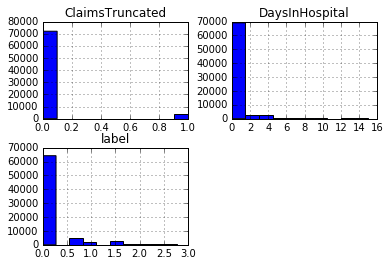

In [75]:
df_target_Y2_transformed.toPandas().hist()

In [71]:
df_target_Y3_transformed.toPandas().describe()

,ClaimsTruncated,DaysInHospital,label
count,71435.000000,71435.000000,71435.000000
mean,0.056611,0.437895,0.178212
std,0.231099,1.531780,0.474091
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,15.000000,2.772589


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf9ddaf550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faf95b79310>]], dtype=object)

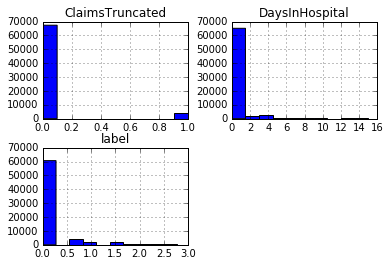

In [76]:
df_target_Y3_transformed.toPandas().hist()

In [74]:
df_target_Y4_transformed.toPandas().describe()

,ClaimsTruncated,DaysInHospital
count,70942.000000,0.0
mean,0.055933,NaN
std,0.229794,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN
max,1.000000,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf95b70f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faf94df1910>]], dtype=object)

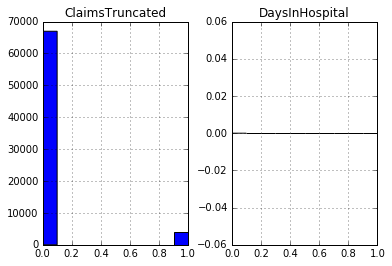

In [77]:
df_target_Y4_transformed.toPandas().hist()